<a href="https://colab.research.google.com/github/AdarshKhatri01/Quantum-MNIST/blob/main/Quantum_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install qiskit pennylane tensorflow matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.0/930.0 kB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 29.9 MB/s eta 0:00:00


In [2]:
import pennylane as qml
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Lambda
from tensorflow.keras.utils import to_categorical

In [3]:
# 1️⃣ Load MNIST Dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train, X_test = X_train[:1000] / 255.0, X_test[:200] / 255.0  # Smaller dataset for Quantum model
y_train, y_test = y_train[:1000], y_test[:200]

# 2️⃣ Reshape for Neural Network
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

# 3️⃣ Convert Labels to One-Hot Encoding
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# 4️⃣ Define Quantum Circuit
n_qubits = 4  # Quantum neurons
n_layers = 2  # Quantum layers

dev = qml.device("default.qubit", wires=n_qubits)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
@qml.qnode(dev, interface="tf", diff_method="backprop")
def quantum_layer(inputs):
    """Quantum layer for the hybrid model.

    Args:
        inputs (tf.Tensor): Input tensor of shape (n_qubits,).

    Returns:
        tf.Tensor: Output tensor of shape (n_qubits,).
    """
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    for _ in range(n_layers):
        qml.BasicEntanglerLayers(weights=np.random.uniform(0, np.pi, (n_layers, n_qubits)), wires=range(n_qubits))
    return qml.probs(wires=range(n_qubits))  # Returns a single tensor instead of multiple values


@tf.function
def quantum_layer_wrapper(inputs):
    """Wrapper function to apply the quantum layer to a batch of inputs.

    Args:
        inputs (tf.Tensor): Input tensor of shape (batch_size, n_qubits).

    Returns:
        tf.Tensor: Output tensor of shape (batch_size, n_qubits).
    """
    # Apply quantum_layer to each sample individually using tf.map_fn
    quantum_output = tf.map_fn(quantum_layer, inputs, fn_output_signature=tf.float64)
    # Ensure proper shape - no need for tf.math.real as qml.probs returns real values
    return quantum_output

In [47]:
# 6️⃣ Build Hybrid Quantum-Classical Model
model = Sequential([
    Flatten(input_shape=(28, 28, 1)),  # Flatten Image
    Dense(n_qubits, activation="relu"),  # Classical Dense Layer
    Lambda(quantum_layer_wrapper),  # Quantum Layer (Fixed with single output tensor)
    Dense(10, activation="softmax")  # Output Layer
])

In [48]:
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_8 (Flatten)                  │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 4)                   │           3,140 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_8 (Lambda)                    │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 10)                  │             170 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,310 (12.93 KB)

 Trainable params: 3,310 (12.93 KB)

 Non-trainable params: 0 (0.00 B)

In [49]:
# 7️⃣ Compile & Train Model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [45]:
# import keras_tuner as kt

# import shutil
# shutil.rmtree('hyperband_tuning')  # Purana tuning cache delete karein

# # Function to create model
# def build_model(hp):
#     # 6️⃣ Build Hybrid Quantum-Classical Model
#     model = Sequential([
#       Flatten(input_shape=(28, 28, 1)),  # Flatten Image
#       Dense(n_qubits, activation="relu"),  # Classical Dense Layer
#       Lambda(quantum_layer_wrapper),  # Quantum Layer (Fixed with single output tensor)
#       Dense(10, activation="softmax")  # Output Layer
#     ])

#     model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#     return model

# # Hyperband tuner
# tuner = kt.Hyperband(build_model,
#                      objective='val_accuracy',
#                      max_epochs=150,
#                      factor=3,
#                      directory='hyperband_tuning',
#                      project_name='batch_size_epochs_tuning')

# # Search for best hyperparameters
# tuner.search(X_train, y_train, validation_data=(X_test, y_test), epochs=50)


# best_hps = tuner.get_best_hyperparameters(num_trials=10)
# if best_hps:
#     print(f"Best Hyperparameters: {best_hps[0].values}")
# else:
#     print("No best hyperparameters found. Tuning may have failed.")


No best hyperparameters found. Tuning may have failed.


In [50]:
history = model.fit(X_train, y_train, epochs=150, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/150
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.0932 - loss: 2.2911 - val_accuracy: 0.2050 - val_loss: 2.2617
Epoch 2/150
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.2681 - loss: 2.2442 - val_accuracy: 0.2250 - val_loss: 2.2322
Epoch 3/150
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.3337 - loss: 2.2086 - val_accuracy: 0.3650 - val_loss: 2.2015
Epoch 4/150
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.4186 - loss: 2.1760 - val_accuracy: 0.4150 - val_loss: 2.1749
Epoch 5/150
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.4639 - loss: 2.1550 - val_accuracy: 0.4300 - val_loss: 2.1492
Epoch 6/150
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5100 - loss: 2.1211 - val_accuracy: 0.4600 - val_loss: 2.1242
Epoch 7/150
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.4656 - loss: 2.1001 - val_accuracy: 0.4550 - val_loss: 2.0999
Epoch 8/150
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.4697 - loss: 2.0763 - val_accuracy: 0.

In [51]:
# 8️⃣ Evaluate Model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"\n✅ Test Accuracy: {test_acc * 100:.2f}%")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5789 - loss: 1.2495

✅ Test Accuracy: 54.00%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


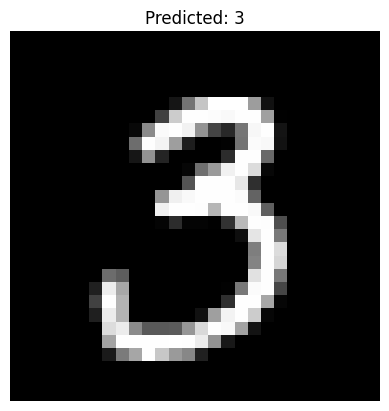

In [57]:
# 9️⃣ Predict a Random Digit
index = np.random.randint(0, len(X_test))
test_image = X_test[index].reshape(1, 28, 28, 1)

prediction = model.predict(test_image)
predicted_label = np.argmax(prediction)

# 🔟 Show Result
plt.imshow(X_test[index].reshape(28, 28), cmap='gray')
plt.title(f"Predicted: {predicted_label}")
plt.axis('off')
plt.show()

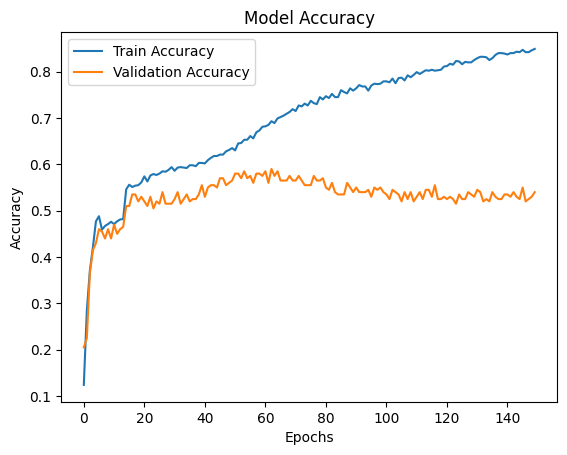

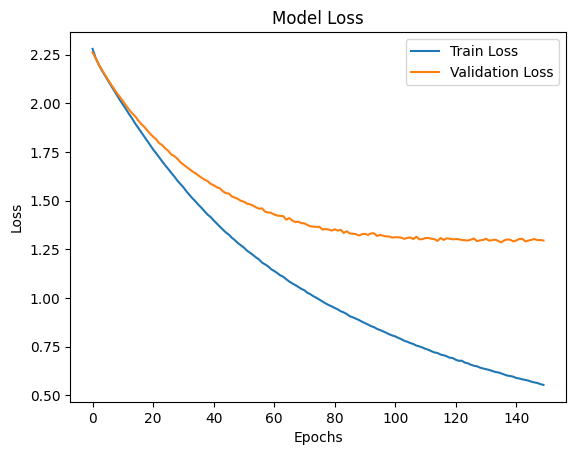

In [54]:
import matplotlib.pyplot as plt

# Plot Training & Validation Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

# Plot Training & Validation Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
plt.show()
